# Regresja logistyczna

## Zadanie na 3

Porównanie sklearn i własnej implementacji klasyfikatora na syntetycznych zbiorach

#### Import bibliotek

In [27]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LogisticRegression

#### Funkcje do oceny skuteczności

In [28]:
def plot_confusion_matrix(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Macierz Pomyłek")
    plt.show()

def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy, sensitivity, specificity

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Losowa klasyfikacja')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Krzywa ROC')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def plot_dataset(X, y, title="Dataset"):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()

#### Wygenerowanie danych 

make_classification

x (2599, 2)
y (2599,)


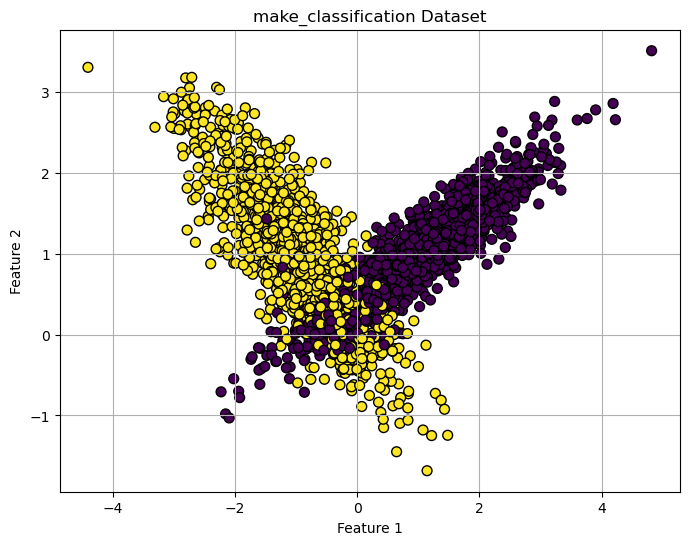

In [29]:
my_index = 259199
my_n_samples = int(str(my_index)[0]+ str(my_index)[1] + str(my_index)[-2] + str(my_index)[-1])
X_classification, y_classification = make_classification(
    n_samples=my_n_samples, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_clusters_per_class=1, 
    random_state=my_index,
)

print('x', X_classification.shape)
print('y', y_classification.shape)
plot_dataset(X_classification, y_classification, title="make_classification Dataset")

make_moons

X_moons (2599, 2)
y_moons (2599,)


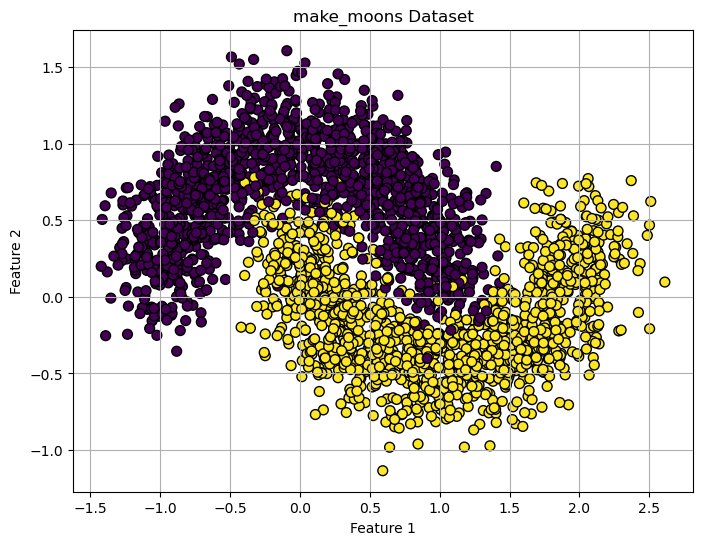

In [30]:
X_moons, y_moons = make_moons(n_samples=my_n_samples, noise=0.2, random_state=my_index)

print('X_moons', X_moons.shape)
print('y_moons', y_moons.shape)
plot_dataset(X_moons, y_moons, title="make_moons Dataset")

#### Podział danych na treningowe i testowe

In [31]:
X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state=my_index
)

X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(
    X_moons, y_moons, test_size=0.2, random_state=my_index
)

print('classification', X_train_classification.shape, y_train_classification.shape, X_test_classification.shape, y_test_classification.shape)
print('moons', X_train_moons.shape, y_train_moons.shape, X_test_moons.shape, y_test_moons.shape)

classification (2079, 2) (2079,) (520, 2) (520,)
moons (2079, 2) (2079,) (520, 2) (520,)


#### Logistic Regression

własna implementacja

In [ ]:
class MyLogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-4, beta=1.0):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.beta = beta
        self.weights = None

    def sigmoid(self, s):
        return 1 / (1 + np.exp(-self.beta * s))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        for iteration in range(self.max_iter):
            linear_output = np.dot(X, self.weights)
            predictions = self.sigmoid(linear_output)
            errors = y - predictions
            gradient = -np.dot(X.T, errors * predictions * (1 - predictions))
            self.weights -= self.learning_rate * gradient
            if np.linalg.norm(gradient) < self.tol:
                print(f"Converged after {iteration + 1} iterations.")
                break

    def predict(self, X):
        linear_output = np.dot(X, self.weights)
        probabilities = self.sigmoid(linear_output)
        return (probabilities >= 0.5).astype(int)

## Zadanie na 4
Poprawny preprocessing danych, nauczenie modeli dla regionów i porównanie ich skuteczności
#### Pobranie danych

In [34]:
file_path = f'./datasets/rainAUS.csv'
data = pd.read_csv(file_path)

print(data.head(), data.shape)

         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

#### Usunięcie kolumn
Mające więcej in 30% brakujących wartości (oraz kolumnę ’Risk-MM’ jeżeli istnieje) 

In [35]:
missing_percentage = data.isnull().mean()  
print("Procent brakujących wartości w każdej kolumnie:\n", pd.DataFrame(missing_percentage))

columns_to_drop = missing_percentage[missing_percentage > 0.3].index
data = data.drop(columns=columns_to_drop)

if 'Risk-MM' in data.columns:
    data = data.drop(columns=['Risk-MM'])

print("Pozostałe kolumny po preprocessingu:", data.columns)

Procent brakujących wartości w każdej kolumnie:
                       0
Date           0.000000
Location       0.000000
MinTemp        0.010209
MaxTemp        0.008669
Rainfall       0.022419
Evaporation    0.431665
Sunshine       0.480098
WindGustDir    0.070989
WindGustSpeed  0.070555
WindDir9am     0.072639
WindDir3pm     0.029066
WindSpeed9am   0.012148
WindSpeed3pm   0.021050
Humidity9am    0.018246
Humidity3pm    0.030984
Pressure9am    0.103568
Pressure3pm    0.103314
Cloud9am       0.384216
Cloud3pm       0.408071
Temp9am        0.012148
Temp3pm        0.024811
RainToday      0.022419
RainTomorrow   0.022460
Pozostałe kolumny po preprocessingu: Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')


## Zadanie na 5
Weryfikacja skuteczności modeli regionalnych na zbiorze krajowym i porównanie skuteczności najlepszego modelu